In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Path to the images directory
images_path = 'PP_Micro'  # Adjust this path to your specific setup

# Function to load images from a directory
def load_images_from_folder(folder):
    images = []
    labels = []
    file_names = [f for f in os.listdir(folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    for filename in file_names:
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            images.append(img)
            labels.append(filename.split('_')[0])  # Assuming filename format is 'label_id.jpg'
    return images, labels

# Function to preprocess images
def preprocess_images(images, size=(224, 224)):
    images_resized = [cv2.resize(img, size) for img in images]
    images_normalized = np.array(images_resized) / 255.0  # Normalize pixel values
    return images_normalized



In [2]:
# Load and preprocess images
from tensorflow.keras.utils import to_categorical
images, labels = load_images_from_folder(images_path)
images_preprocessed = preprocess_images(images)

# Encode labels - simple numerical encoding and convert to one-hot
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)
labels_one_hot = to_categorical(labels_encoded)

In [3]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load ResNet50 base model without the top
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')  # Assuming 3 classes for the task
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [4]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=0.001,
    verbose=1
)

In [5]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
num_folds = 4
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

X_train, X_test, Y_train, Y_test = train_test_split(images_preprocessed, labels_one_hot, test_size=0.1, random_state=42)

# Prepare to collect scores
fold_no = 1
loss_per_fold = []
accuracy_per_fold = []

for train_idx, val_idx in kfold.split(X_train, Y_train):
    print(f'Training fold {fold_no}...')
    
    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = Y_train[train_idx], Y_train[val_idx]

    # Fit the model
    history = model.fit(
        X_train_fold, y_train_fold,
        batch_size=32,
        epochs=20,
        verbose=1,
        validation_data=(X_val_fold, y_val_fold),
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the model
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: Loss = {scores[0]}; Accuracy = {scores[1]*100}%')
    loss_per_fold.append(scores[0])
    accuracy_per_fold.append(scores[1] * 100)

    # Increment the fold number
    fold_no += 1

# Provide average scores
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print(f'Average scores for all folds: Accuracy: {np.mean(accuracy_per_fold):.2f}%, Loss: {np.mean(loss_per_fold):.2f}')
print('------------------------------------------------------------------------')


Training fold 1...
Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.2002 - loss: 2.2127 - val_accuracy: 0.1824 - val_loss: 2.0146 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.4320 - loss: 1.6324 - val_accuracy: 0.4595 - val_loss: 1.5447 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5666 - loss: 1.3076 - val_accuracy: 0.5608 - val_loss: 1.4046 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5964 - loss: 1.2178 - val_accuracy: 0.5473 - val_loss: 1.3695 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5973 - loss: 1.1780 - val_accuracy: 0.5878 - val_loss: 1.3391 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6861 - loss: 0.9967 - val_accuracy: 0.5270 - val_loss: 1.4315 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.6820 - loss: 0.98

In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_val_fold, y_val_fold)
print(f"Validation accuracy: {test_accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7404 - loss: 0.8135
Validation accuracy: 0.7210884094238281


In [13]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print(scores)

[0.9215339422225952, 0.7435897588729858]


In [8]:
import pickle

# Save history to a pickle file
with open('VGG_History.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
with open('model_history.pkl', 'rb') as f:
    loaded_history = pickle.load(f)

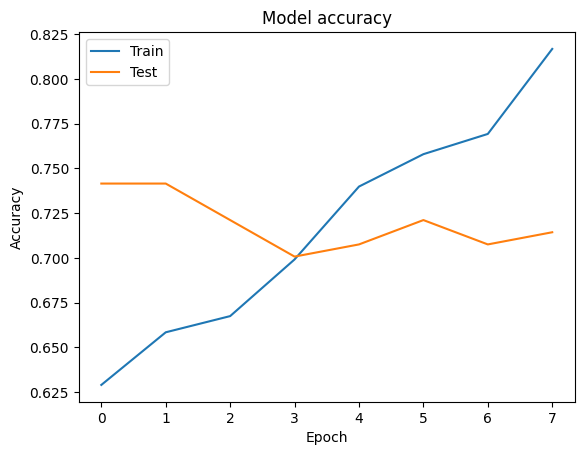

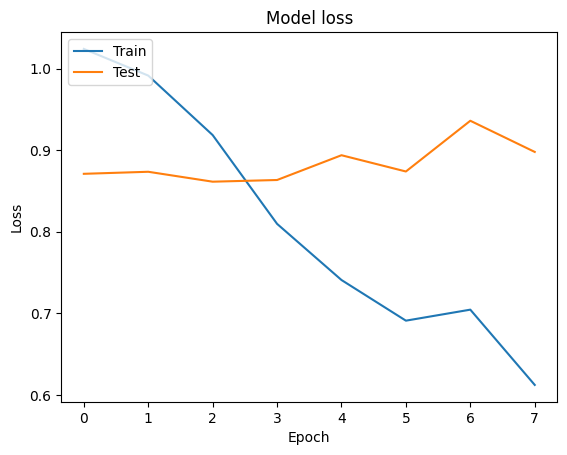

In [9]:
# Plot training & test accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & test loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [10]:
def plot_predictions(r=5 ,c =5):
  w=10
  h=10
  fig=plt.figure(figsize=(12, 12))
  columns = c
  rows = r
  for i in range(1, columns*rows +1):
      fig.add_subplot(rows, columns, i)
      rand_n = np.random.randint(X_val_fold.shape[0])
      plt.imshow(X_val_fold[rand_n][:, :, 0], cmap='gray')
      plt.title(f'Actual:{np.argmax(y_val_fold[rand_n])} Predicted: {np.argmax(model.predict(X_val_fold[rand_n].reshape(-1, 224, 224, 3)))}');
      plt.axis('off')
  plt.show()

In [11]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_val_fold, axis=1), np.argmax(model.predict(X_val_fold),axis=1)))

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
              precision    recall  f1-score   support

           0       0.39      1.00      0.57        13
           1       0.94      0.81      0.87        21
           2       0.87      0.72      0.79        18
           3       0.81      0.65      0.72        20
           4       0.65      0.62      0.63        21
           5       0.93      0.65      0.76        20
           6       0.76      0.72      0.74        18
           7       0.79      0.69      0.73        16

    accuracy                           0.72       147
   macro avg       0.77      0.73      0.73       147
weighted avg       0.78      0.72      0.73       147



5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


<Axes: xlabel='Predicted', ylabel='Actual'>

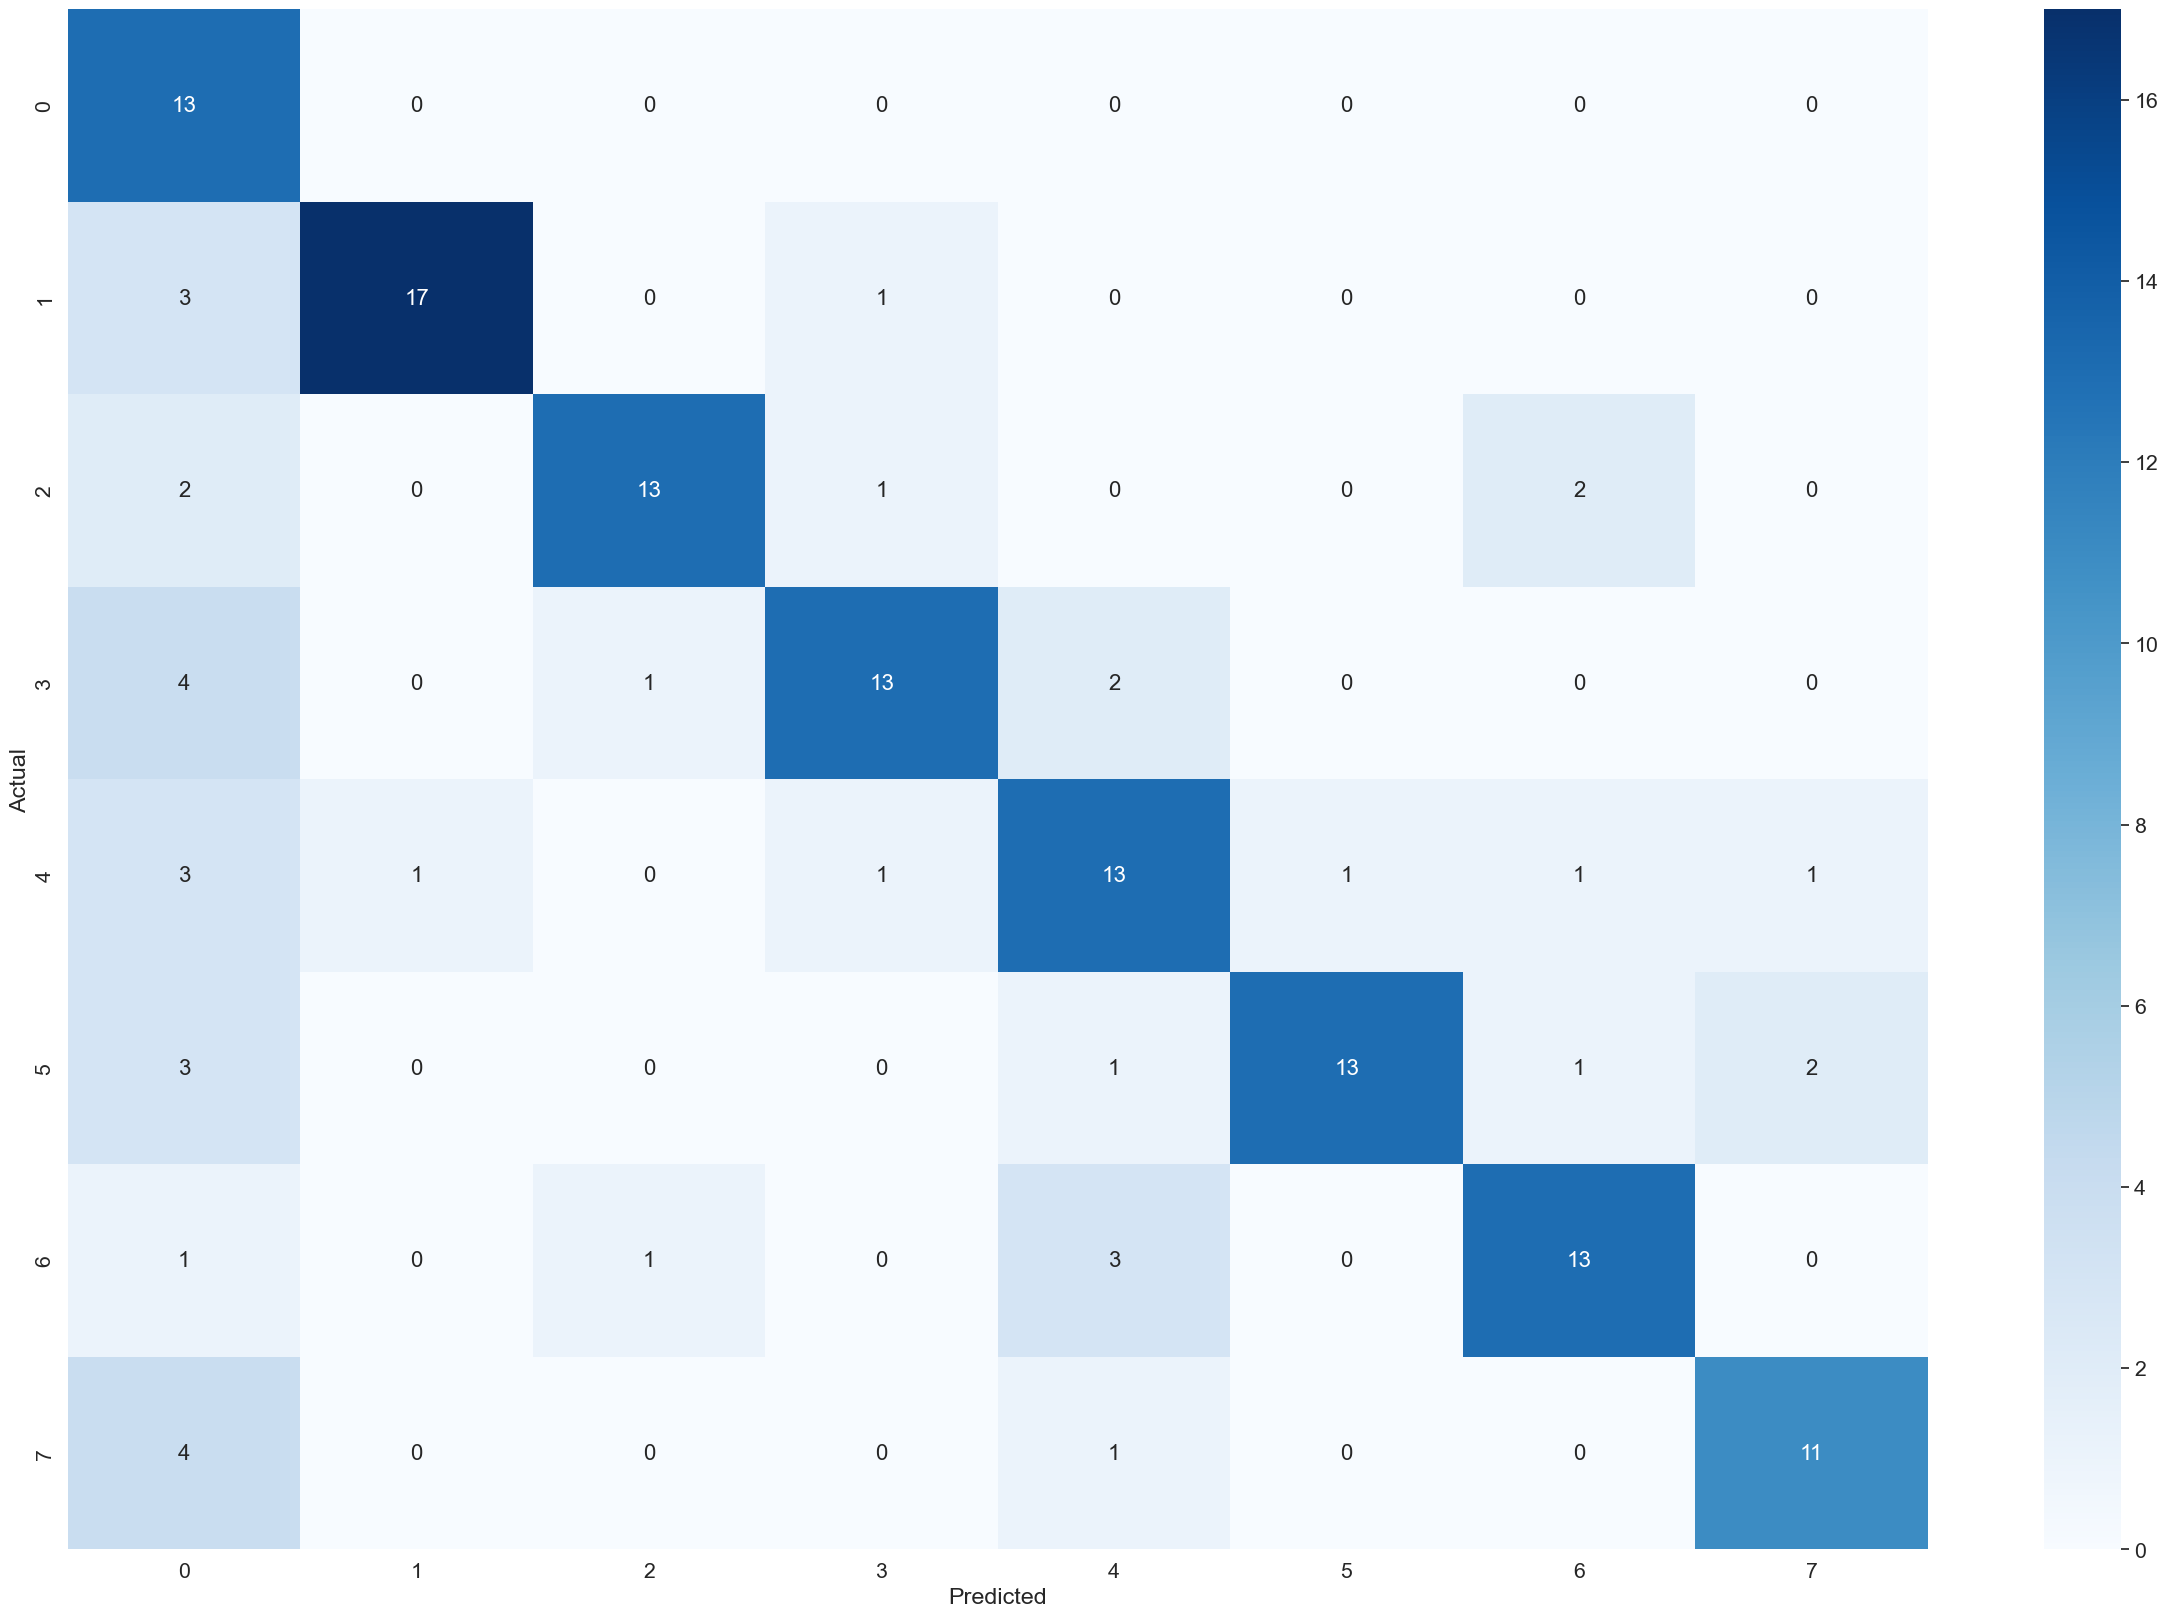

In [24]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score
import seaborn as sn
import pandas as pd
y_true = np.argmax(y_val_fold, axis=1)
y_pred = np.argmax(model.predict(X_val_fold), axis=1)
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (30,20))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


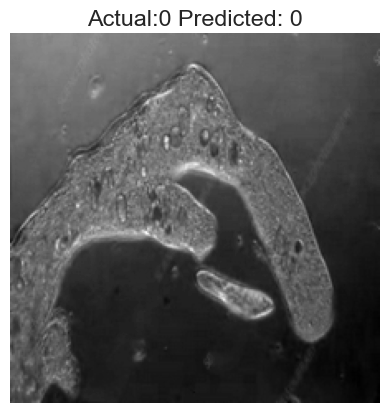

In [17]:
rand_n = np.random.randint(X_val_fold.shape[0])
plt.imshow(X_val_fold[rand_n][:, :, 0], cmap='gray')
plt.title(f'Actual:{np.argmax(y_val_fold[rand_n])} Predicted: {np.argmax(model.predict(X_val_fold[rand_n].reshape(-1, 224, 224, 3)))}');
plt.axis('off')
plt.show()